# Information Retrieval - Pandemic Investigation

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

from gensim.models.coherencemodel import CoherenceModel

import TextCleaning

In [2]:

# CLEANED AND PROCESSED DATA PULL - processed abstracts are in docs column.  Will need to create new
# corpus and id2word

# import NSF data
#f = open('../../data/prd/RND Topic Modelling/nsf_stanford_lemma.sav', 'rb')

# import entire dataset
f = open('../../data/prd/RND Topic Modelling/lda_data_stanford_lemma.sav', 'rb')

[temp1, temp2, docs] = pickle.load(f)
f.close()

# corpus - word frequency in docs
# id2word - dictionary
# docs - lemmatized abstracts

# from Sam's code

#docs=docs.reset_index(drop=True)  
docs = docs.loc[docs.apply(lambda x: len(x)>0)] #No duplicates removed here
docs = docs.reset_index(drop=True)


In [3]:

# input needed for doc-term matrix creation is one string per document (not a list of strings).  

text = []
for doc in docs:
    text.append(" ".join(doc))    


In [2]:
# ORIGINAL DATA PULL

# pull in original abstracts

raw_df=pd.read_csv('../../data/prd/RND Topic Modelling/abstracts_federal_reporter_combined.csv',engine='python')

# remove null abstracts and duplicates

df = TextCleaning.remove_nulls(raw_df, "ABSTRACT")
df = TextCleaning.remove_duplicates(df)

df.reset_index(inplace = True)
df.rename(columns={'index':'original index'}, inplace=True)

df.head()

3 nulls in  ABSTRACT . These rows removed.
11 duplicate abstracts removed
0 project ID duplicates - not removed


,original index,PROJECT_ID,ABSTRACT,FY,FIRST_CHAR,LAST_CHAR,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_TITLE,PROJECT_TERMS,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,ORGANIZATION_NAME,CFDA_CODE,FY_TOTAL_COST
0,0,89996,"This is a project to explore Game-based, Metap...",2008,"This is a project to explore Game-based, Metap...",.,NSF,NSF,NaN,0814512,RUI: CYGAMES: CYBER-ENABLED TEACHING AND LEARN...,Achievement; analog; base; Cognitive Science; ...,"REESE, DEBBIE D","CARTER, BEVERLY; WOOD, CHARLES; HITT, BEN",WHEELING JESUIT UNIVERSITY,47.076,1999467.0
1,1,89997,Institution: Franklin Institute Science Museum...,2008,Institution: Franklin Institute Science Museum...,.,NSF,NSF,NaN,0741659,ARIEL - AUGMENTED REALITY FOR INTERPRETIVE AND...,Active Learning; Child; Computer software; des...,"SNYDER, STEVEN","ELINICH, KAREN; YOON, SUSAN",FRANKLIN INSTITUTE,47.076,1799699.0
2,2,89998,Through programs (including small group conver...,2008,Through programs (including small group conver...,.,NSF,NSF,NaN,0813522,BRIGHTER FUTURES: PUBLIC DELIBERATION ABOUT TH...,Address; Age; Birth; Brain; Caregivers; Child;...,"FINK, LAURIE KLEINBAUM","CADIGAN, KAREN; ELLENBOGEN, KIRSTEN",SCIENCE MUSEUM OF MINNESOTA,47.076,1505858.0
3,3,89999,In partnership with the American Chemical Soci...,2008,In partnership with the American Chemical Soci...,.,NSF,NSF,NaN,0838627,FOSTERING US-INTERNATIONAL COLLABORATIVE PARTN...,Advanced Development; American; Chemicals; Che...,"JOST, JOHN W","MILLER, BRADLEY; BOWMAN, KATHERINE",INTERNATIONAL UNION OF PURE AND APPLIED CHEMISTRY,47.049,51000.0
4,4,90000,Amphibian populations around the world are exp...,2008,Amphibian populations around the world are exp...,.,NSF,NSF,NaN,0815315,COLLABORATIVE RESEARCH: EVOLUTION OF AMPHIBIAN...,Amphibia; Central America; Communicable Diseas...,"ZAMUDIO, KELLY R",NaN,CORNELL UNIVERSITY ITHACA,47.074,370996.0


In [3]:
docs = df["ABSTRACT"]

# input needed for doc-term matrix creation is one string per document (not a list of strings).  Original data is
# already in this form!

text = df["ABSTRACT"]


## Functions needed for all approaches

In [4]:
# Create query vector 

def create_query(words, terms):
    
    # words: search query words
    # terms: terms in corpus
    
    q = np.zeros(len(terms))  # number of terms

    idx = []
    for word in query_words:
        idx.append(terms.index(word))

    q[idx] = 1
    
    return q

In [5]:
def return_top_abstracts(docs, scores, top_n):
    
    '''
    docs: Series that contains abstract
    scores: scores of abstracts
    top_n: return the top_n abstracts given by idx, if -1 return all abstracts
    '''
    # sort scores in descending order
    scores_sorted_idx = np.argsort(scores)[::-1]
    
    if top_n == -1:
        ix = scores_sorted_idx
    else:
        ix = scores_sorted_idx[:top_n]
    
    print(ix[0:10])
    
    return ix, docs[ix]
    

In [6]:
def create_result_df(abstracts, scores):
    
    df = pd.DataFrame()
    df["abstracts"] = abstracts
    df["scores"] = scores
    
    return df

## Exact word matches - Frequency Count Document-Term Matrix

This will return all abstracts in the corpus with exact word matches to the query.  A query is just a list of words to search for.

Results will be return in sorted order of how high the query scores with each abstract. A high score means more occurences of the query words in the abstract.

In [7]:
# Create document-term matrix based on count frequencies

vectorizer = CountVectorizer()
doc_term_matrix = vectorizer.fit_transform(text)

In [8]:
terms = vectorizer.get_feature_names()

In [9]:
# exploring terms

print(len(terms))
terms[18400:18500]

1098073


['ackowledge',
 'ackowledgedne',
 'ackr',
 'ackr1',
 'ackr3',
 'ackr3undergo',
 'ackr4',
 'acl',
 'acl2',
 'acl3',
 'acl5',
 'acl_accesscontrollist',
 'acl_accesscontrollist_collaborate',
 'acl_injure',
 'acl_intact',
 'acl_reconstruct',
 'acl_reconstruction',
 'acl_rupture',
 'acl_tear',
 'acl_transection',
 'aclacinomycin',
 'aclaim',
 'aclam',
 'aclam_board',
 'aclam_certify',
 'aclaris',
 'aclass',
 'aclassic',
 'aclassical',
 'aclassification',
 'aclassroom',
 'aclc',
 'aclcan',
 'acld',
 'acldl',
 'aclean',
 'aclear',
 'aclearance',
 'aclearer',
 'acleavage',
 'acli',
 'aclient',
 'aclimate',
 'aclimation',
 'aclinic',
 'aclinical',
 'aclinically',
 'aclinically_relevant',
 'aclinician',
 'aclinjury',
 'acliprogram',
 'aclm',
 'aclministrative',
 'aclonal',
 'aclose',
 'aclosely',
 'acloser',
 'aclot',
 'acloud',
 'aclp',
 'aclr',
 'aclrand',
 'aclreconstruction',
 'aclrepair',
 'acls',
 'aclsurgery',
 'aclt',
 'acltear',
 'acluster',
 'aclutter',
 'acly',
 'aclzip',
 'acm',
 'ac

In [10]:
# CHANGE QUERY WORDS HERE - this query vector can be used for all three IR approaches! term list from 
# CountVectorizer and TFIDF are the same and in same order so no need to create new query for each approach

# find all tokens with pandemic

s0 = "1918"
q0 = [token for token in terms if s0 in token]  # length 79

#s1 = "pandemia"
#q1 = [token for token in terms if s1 in token]   # length 1

query_words = q0 #+ q1

#query_words = ["influenza"]
q = create_query(query_words, terms)

In [11]:
print(q0)

['anti_1918', 'pre_1918']


In [13]:
# calculate the score for each document against the query. Docs with more occurences of the query words 
# will score higher

f_scores = doc_term_matrix.dot(q)

In [14]:
max_nnz = sum(f_scores >0)
print(max_nnz)

4


In [15]:
# sort scores in descending order

f_scores_sorted = np.sort(f_scores)[::-1]
f_scores_sorted[:10]

array([4., 4., 4., 2., 0., 0., 0., 0., 0., 0.])

In [16]:
f_idx, f_top_abstracts = return_top_abstracts(docs, f_scores, 100) #max_nnz)

[143617 190307  91351 160556 181131 181132 181133 181134 181130 181135]


In [17]:
f_top_abstracts

143617    [influenza, virus, significant, human, pathoge...
190307    [influenza, virus, significant, human, pathoge...
91351     [influenza, virus, significant, human, pathoge...
160556    [current, vaccine, induce, generation, cell, s...
181131    [analysis, gene, expression, data, cancer, cla...
                                ...                        
181219    [sox2, transcription, factor, know, glcnacylat...
181220    [cell, acute_lymphoblastic_leukemia, lymphoma,...
181221    [caspase, conserve, caspase, different, specie...
181222    [glycosylation, important, widespread, type, p...
181193    [protease, encode, human, genome, involved, di...
Name: final_tokens, Length: 100, dtype: object

In [ ]:
print(f_top_abstracts.iloc[9])

In [ ]:
f_df = create_result_df(docs, f_scores)

In [ ]:
f_df

## TF-IDF approach

In [15]:
# Find doc-term matrix using TF-IDF weighting

tf_idf_vectorizer = TfidfVectorizer()
tf_idf = tf_idf_vectorizer.fit_transform(text)

In [16]:
# same list as "terms" from CountVectorizer

tf_idf_terms = tf_idf_vectorizer.get_feature_names()

In [17]:
# exploring tf_idf_terms

len(tf_idf_terms)

1058314

In [18]:
# check if terms list from CountVectorizer and TfidfVectorizer are the same - they should be, THEY ARE

terms == tf_idf_terms

True

In [ ]:
# I don't need this as it created the exact same query as the create_query function

'''
# transform query to be in same space as documents
# q = q.reshape(1,-1)
qhat = tf_idf_vectorizer.transform(query_words)

temp = qhat.toarray()
qhat = np.reshape(temp, qhat.shape[1])

tf_idf_scores = pairwise_distances(qhat, tf_idf, metric='cosine', n_jobs=19)
'''

In [19]:
# calculate the score for each document against the query. Docs with more occurences of the query words 
# will score higher

tf_idf_scores = tf_idf.dot(q)

In [20]:
max_nnz = sum(tf_idf_scores >0)
print(max_nnz)

1884


In [21]:
# sort scores in descending order

tf_idf_scores_sorted = np.sort(tf_idf_scores)[::-1]
tf_idf_scores_sorted[:10]

array([0.84638909, 0.83490343, 0.78848695, 0.7683569 , 0.69023329,
       0.67756645, 0.58684808, 0.57074084, 0.5554081 , 0.55530964])

In [22]:
tfidf_idx, tfidf_top_abstracts = return_top_abstracts(docs, tf_idf_scores, 100) #max_nnz)

[147574 292930 346289 236762  85470 148102  62499 436945 298556 194186]


In [23]:
tfidf_top_abstracts

147574    Influenza A viruses (IAV) are significant huma...
292930    DESCRIPTION (provided by applicant): Influenza...
346289    PROJECT SUMMARY / ABSTRACTInfluenza pandemics ...
236762    Influenza A viruses are significant human path...
85470     DESCRIPTION (provided by applicant): The pande...
                                ...                        
45334     DESCRIPTION (provided by applicant): Increased...
399404    DESCRIPTION (provided by applicant): An enormo...
127235    DESCRIPTION (provided by applicant): The CDC's...
147092    This contract supports the preclinical, noncli...
19026     DESCRIPTION (provided by applicant): The long-...
Name: ABSTRACT, Length: 100, dtype: object

In [ ]:
print(tfidf_top_abstracts.iloc[1881])

In [ ]:
# 1) scores order may differ from Count Vectorizer....why? --- term frequency (tf) weight depends on term frequency
# in doc AND number of terms in doc

# 2) if returning all relevant documents, the rel docs list from CountVectorizer and TFIDF should be the same, 
# just in a diff order --- YES, TRUE


In [24]:
# check #2

# check if terms list from CountVectorizer and TfidfVectorizer are the same - they should be, THEY ARE

set(f_idx) == set(tfidf_idx)  # when we take all relevant docs.  order doesn't matter, only inclusion in the set

False

In [ ]:
tf_idf_df = create_result_df(docs, tf_idf_scores)

In [ ]:
tf_idf_df

## Latent Semantic Indexing (LSI) Approach

Uses the TF-IDF matrix.

In [25]:
# Find the Truncated SVD of the TF-IDF matrix -- 

lsa = TruncatedSVD(n_components=500, random_state=1)
USigma = lsa.fit_transform(tf_idf)
Vtrans = lsa.components_

In [26]:
# transform query to be in same space as documents

#q = q.reshape(1,-1)
qhat = lsa.transform(q.reshape(1,-1))

In [27]:
print(qhat.shape)
print(USigma.shape)
print(Vtrans.shape)

(1, 500)
(550074, 500)
(500, 1058314)


In [28]:
lsa_scores = pairwise_distances(qhat, USigma, metric='cosine', n_jobs=19)

In [ ]:
print(lsa_scores.shape)
print(type(lsa_scores))

In [72]:
lsa_scores

array([[1.00842145, 1.00341966, 0.99659346, ..., 1.01601745, 1.00529736,
        1.00621292]])

In [29]:
lsa_scores[0]

array([1.00842145, 1.00341966, 0.99659346, ..., 1.01601745, 1.00529736,
       1.00621292])

In [30]:
max_nnz = sum(lsa_scores[0] > 0)
print(max_nnz)

550074


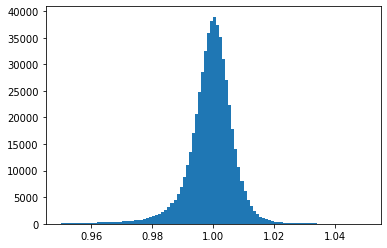

In [31]:
plt.hist(lsa_scores[0], bins=100, range = (0.95, 1.05));

In [32]:
print(lsa_scores[0].min())
print(np.percentile(lsa_scores[0], [25, 50, 75]))
print(lsa_scores[0].max())

0.0773929631152116
[0.99564568 0.99981852 1.00359385]
1.0798677473228107


In [33]:
# sort scores in descending order

lsa_scores_sorted = np.sort(lsa_scores[0])[::-1]
lsa_scores_sorted[0:10]

array([1.07986775, 1.07961181, 1.07718647, 1.07648677, 1.07633429,
       1.07581714, 1.07521699, 1.07322336, 1.07106421, 1.06939388])

In [34]:
lsa_idx, lsa_top_abstracts = return_top_abstracts(docs, lsa_scores[0], 100)

[120887 412678 516916 410792 483108 499717 119396 222388 444202 523151]


In [35]:
lsa_top_abstracts

120887    Dengue fever is one of the most important emer...
412678    Abstract A reduction in disease severity is th...
516916    We initially focused on a PIV3-based vector to...
410792    ﻿   DESCRIPTION (provided by applicant): Respi...
483108    ﻿DESCRIPTION (provided by applicant): Respirat...
                                ...                        
28495     DESCRIPTION (provided by applicant): The long ...
120489    The four serotypes of Dengue virus (DENV) caus...
137522    This subproject is one of many research subpro...
26215     DESCRIPTION (provided by applicant):  Chronic ...
537058    Project Summary/AbstractAn estimated 2.3 billi...
Name: ABSTRACT, Length: 100, dtype: object

In [ ]:
print(lsa_top_abstracts.iloc[499])

In [ ]:
lsa_df = create_result_df(docs, lsa_scores[0])

In [ ]:
lsa_df

## Topic Modeling with relevant pandemic abstracts

#### Functions needed for coherence

In [36]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function slightly modified from https://nlpforhackers.io/topic-modeling/

def list_topics(model, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        #print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
        
    return topic_words

In [37]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)

#### Topic Model

In [38]:
docs_ix = np.concatenate([f_idx, tfidf_idx, lsa_idx])

In [39]:
docs_idx = np.unique(docs_ix)

In [40]:
docs_idx.shape

(229,)

In [42]:
type(docs_idx)

numpy.ndarray

In [41]:
# for topic modeling - needs each document as a string

lim_docs = [text[i] for i in docs_idx]

In [57]:
nmf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=3, lowercase=False) #max_features=5000)
nmf_tf_idf = nmf_vectorizer.fit_transform(lim_docs)

In [50]:
terms = nmf_vectorizer.get_feature_names()

In [51]:
len(terms)

3063

In [ ]:
terms[0:20]

In [58]:
# topic modeling with NMF

nmf_model = NMF(n_components=10, random_state=1)
W = nmf_model.fit_transform(nmf_tf_idf)
H = nmf_model.components_

In [66]:
print(W.shape)
print(H.shape)

(129, 10)
(10, 2177)


In [59]:
print_topics(nmf_model, nmf_vectorizer, 10)


Topic 0:
('influenza', 0.6925119372770508)
('vaccine', 0.5953179993911152)
('vaccines', 0.4786075960368146)
('against', 0.42866673950617196)
('viruses', 0.4248486365251964)
('pandemic', 0.40280025824357285)
('H1N1', 0.37260985004338953)
('HA', 0.30063005019873884)
('protection', 0.27031331347618687)
('H5N1', 0.25732732550273457)

Topic 1:
('RSV', 1.5243507965778025)
('asthma', 0.2423471795762382)
('airway', 0.21940452537878224)
('bronchiolitis', 0.21403705374980714)
('disease', 0.1926697547805739)
('mucus', 0.17491567476433534)
('induced', 0.16300473466497625)
('expression', 0.16275253834346795)
('PGI2', 0.15727626234660244)
('IL', 0.15043161964051824)

Topic 2:
('ZIKV', 1.5104856876928994)
('DENV', 0.2071207540742691)
('Zika', 0.17189276639934517)
('microcephaly', 0.15247728665228505)
('NS3', 0.12291441836474021)
('flavivirus', 0.10378746163123377)
('exposure', 0.0899527126665448)
('protease', 0.08444849103403383)
('pregnancy', 0.08355858461180261)
('maternal', 0.0827371176475094)

T

In [54]:
topics = list_topics(nmf_model, nmf_vectorizer, top_n=10)

#### Coherence Calculation

In [55]:
# for coherence - needs each document as a list of tokens

lim_docs_c = [docs[i] for i in docs_idx]

In [56]:
# Create corpus and dictionary for the limited corpus: dictionary (id2word), corpus
    
# Create Dictionary
id2word = gensim.corpora.Dictionary(lim_docs_c)
id2word.filter_extremes(no_below=3, no_above=0.9)#, keep_n=5000)

# Create Corpus (Term Document Frequency)

#Creates a count for each unique word appearing in the document, where the word_id is substituted for the word
corpus = [id2word.doc2bow(doc) for doc in lim_docs_c]
 

TypeError: doc2bow expects an array of unicode tokens on input, not a single string

In [ ]:
cm = CoherenceModel(topics=topics, corpus=corpus, dictionary=id2word, texts=lim_docs_c, 
                            coherence='c_v', processes=1) #window_size=500 ) 
cm.get_coherence()

In [ ]:
terms_dict = id2word.token2id
terms_dict

In [ ]:
# Look at sci kit learn tfidf how tokens are formed...alpha numeric only...

In [ ]:
id2word.get(3)

In [ ]:
id2word.cfs

In [ ]:
# sci-kit learn is keeping the most n frequent tokens by term frequency across corpus, 
# id2word is "Keep only the first keep_n most frequent tokens." not exactly sure if this is in corpus?
# if there is a tie break for same frequency it appears that scikit learn may be abc order?  and id2word is order
# in corpus?

# Fix: use more words for keep_n in id2word.filter_extremes

### Hierarchical Dirichlet Process

In [ ]:
from gensim.models import HdpModel

In [ ]:
t1 = time.time()
hdp_model = HdpModel(corpus=corpus, id2word=id2word, random_state=1)
t2 = time.time()

print("Time = ", t2-t1, "seconds")

In [ ]:
TT = hdp_model.get_topics()

In [ ]:
TT.shape


In [ ]:
# To get the topic words from the model
topics = []
for topic_id, topic in hdp_model.show_topics(num_topics=150, formatted=False):
    topic = [word for word, _ in topic]
    topics.append(topic)
topics[:30]